In [6]:
import folium
import pandas as pd
import numpy as np
import geopandas as gpd
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

import networkx as nx



In [7]:
def get_start_end_coordinates(geom):
    start_points = []
    end_points = []
    for line in geom.geoms:  # Access individual LineString geometries within the MultiLineString
        start_points.append(line.coords[0])   # Get the first coordinate of each LineString
        end_points.append(line.coords[-1])    # Get the last coordinate of each LineString
    return start_points, end_points



### Read in the data
uses HIFLD data: https://hifld-geoplatform.hub.arcgis.com/datasets/geoplatform::transmission-lines

In [8]:
%%time


# Load & Read GeoJSON file

# file_path = "/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/physical_grid_data/US_Electric_Power_Transmission_Lines_-3845977064911730921.geojson"
# gdf = gpd.read_file(file_path)
# # gdf = gdf.to_crs(epsg=3857)
# gdf = gdf.to_crs(epsg=4326)
 

# # Convert timeframes to folium-friendly types
# gdf['SOURCEDATE'] = pd.to_datetime(gdf['SOURCEDATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')
# gdf['VAL_DATE'] = pd.to_datetime(gdf['VAL_DATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')


file_path = "/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/physical_grid_data/U.S._Electric_Power_Transmission_Lines.geojson"
gdf = gpd.read_file(file_path)
# gdf = gdf.to_crs(epsg=3857)
# gdf = gdf.to_crs(epsg=4326)

 

# Convert timeframes to folium-friendly types
gdf['SOURCEDATE'] = pd.to_datetime(gdf['SOURCEDATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')
gdf['VAL_DATE'] = pd.to_datetime(gdf['VAL_DATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')


# Drop columns with 'NOT AVAILABLE' as substation value
# gdf[ (gdf['SUB_1']=='NOT AVAILABLE') | (gdf['SUB_2']=='NOT AVAILABLE')]
condition = ( (gdf['SUB_1']=='NOT AVAILABLE') | (gdf['SUB_2']=='NOT AVAILABLE') )
gdf = gdf[~condition]
# gdf

# Drop columns with 'NONE' as substation value
condition = ( (gdf['SUB_1']=='NONE') | (gdf['SUB_2']=='NONE') )
gdf = gdf[~condition]
gdf


CPU times: user 30.8 s, sys: 514 ms, total: 31.3 s
Wall time: 31.4 s


,FID,OBJECTID,ID,TYPE,STATUS,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,...,OWNER,VOLTAGE,VOLT_CLASS,INFERRED,SUB_1,SUB_2,SHAPE__Len,GlobalID,SHAPE_Length,geometry
0,1,501,135919,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2014-08-04T00:00:00,IMAGERY,...,NOT AVAILABLE,69.0,UNDER 100,Y,UNKNOWN115865,TAP142941,29.188701,{73B386A9-AE19-4673-AE34-A87E1E490FE1},0.000227,"MULTILINESTRING ((-92.27198 30.22732, -92.2720..."
1,2,502,141425,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2014-04-07T00:00:00,IMAGERY,...,ALABAMA POWER CO,115.0,100-161,Y,UNKNOWN109093,TAP142857,74.705018,{9EA82903-87B1-4BB6-84B5-9B372F739699},0.000583,"MULTILINESTRING ((-87.82312 30.60263, -87.8232..."
2,3,503,141426,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2014-07-15T00:00:00,IMAGERY,...,"DUKE ENERGY CAROLINAS, LLC",100.0,100-161,Y,UNKNOWN115051,TAP154872,70.223774,{6008C7EC-8421-487A-9CB1-22801412BEB7},0.000591,"MULTILINESTRING ((-81.85754 35.03416, -81.8580..."
3,4,504,141429,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.oatioasis.c...",2014-07-08T00:00:00,IMAGERY,...,TENNESSEE VALLEY AUTHORITY,161.0,100-161,N,FORT PAYNE PRIMARY,TAP152965,12929.295887,{1678DB1B-7C05-4927-A0FA-7E9011CABC1A},0.109258,"MULTILINESTRING ((-85.68872 34.47813, -85.6893..."
4,5,505,141422,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2015-05-28T00:00:00,IMAGERY,...,COMMONWEALTH EDISON CO,138.0,100-161,Y,UNKNOWN121903,TAP137923,1737.440378,{DE001834-13ED-4FE4-96CC-789BDF3B01F9},0.012158,"MULTILINESTRING ((-87.96213 42.03757, -87.9625..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93042,93043,93043,315082,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Western Electricity Coordinating Council https...,2017-01-01T00:00:00,IMAGERY/OTHER,...,NOT AVAILABLE,230.0,220-287,N,TAP317033,LONE BUTTE,3437.236752,{99755F96-1FD1-403B-9A00-7351EF073AA3},0.025857,"MULTILINESTRING ((-111.99586 33.22352, -111.99..."
93043,93044,93044,315083,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2019-11-23T00:00:00,IMAGERY,...,"ENTERGY TEXAS, INC.",138.0,100-161,Y,TAP316626,TAP316629,3287.127256,{4DD4F2D4-470F-4C1F-9948-C28B485F733D},0.028136,"MULTILINESTRING ((-94.06849 30.05597, -94.0669..."
93044,93045,93045,315084,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2019-11-23T00:00:00,IMAGERY,...,"ENTERGY TEXAS, INC.",138.0,100-161,Y,TAP316627,TAP316630,103.168311,{1FFEACEF-46E0-49EA-9367-CBD918C10A35},0.000803,"MULTILINESTRING ((-94.06840 30.05450, -94.0684..."
93045,93046,93046,315085,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2019-11-23T00:00:00,IMAGERY,...,"ENTERGY TEXAS, INC.",138.0,100-161,Y,TAP316630,TAP316629,90.248211,{CDB30F46-7C14-47A6-A16F-E8ED2DC404F1},0.000707,"MULTILINESTRING ((-94.06846 30.05530, -94.0685..."


In [9]:
# Apply the start and end points function to the MultiLineString geometry
gdf['start_points'], gdf['end_points'] = zip(*gdf['geometry'].apply(lambda geom: get_start_end_coordinates(geom)))


### Building the graph directly from start and end points rather than substation names

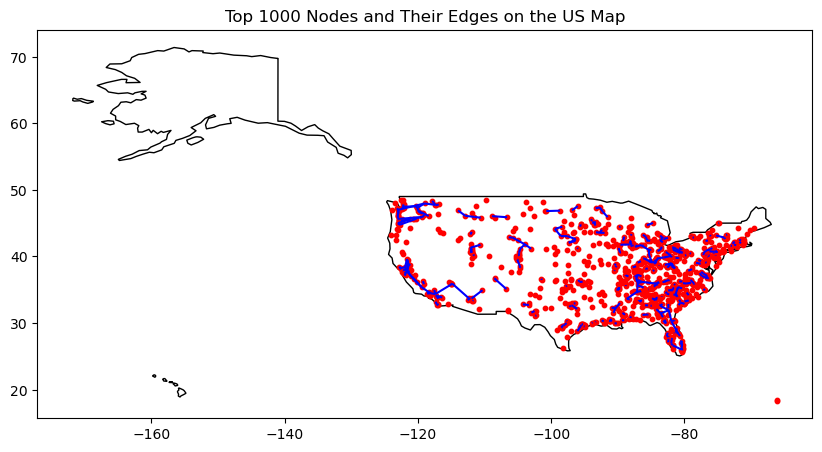

In [15]:
from shapely.geometry import Point, LineString

# Create a NetworkX graph
G = nx.Graph()

# Add edges to the graph
for idx, row in gdf.iterrows():
    start = tuple(row['start_points'])
    end = tuple(row['end_points'])
    start_id = f"{start[0][0]}_{start[0][1]}"
    end_id = f"{end[0][0]}_{end[0][1]}"
    G.add_edge(start_id, end_id, geometry=LineString([start[0], end[0]]))


# Calculate degree centrality
centrality = nx.degree_centrality(G)

# Get the top X nodes based on degree centrality
num_nodes = 1000
top_X_nodes = sorted(centrality, key=centrality.get, reverse=True)[:num_nodes]

# Get the subgraph of the top X nodes
subgraph = G.subgraph(top_X_nodes)

# Create a GeoDataFrame of the edges for plotting
edges = []
for u, v, data in subgraph.edges(data=True):
    start_coords = tuple(map(float, u.split('_')))
    end_coords = tuple(map(float, v.split('_')))
    edges.append(LineString([start_coords, end_coords]))

edges_gdf = gpd.GeoDataFrame(geometry=edges)

# Create a GeoDataFrame of the nodes for plotting
nodes = [Point(tuple(map(float, node.split('_')))) for node in top_X_nodes]
nodes_gdf = gpd.GeoDataFrame(geometry=nodes)


# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the US map using GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = world[world.name == "United States of America"]
us.plot(ax=ax, color='white', edgecolor='black')

# # Create a Basemap object
# plt.figure(figsize=(20,20))
# m = Basemap(llcrnrlon=-130, llcrnrlat=20, urcrnrlon=-60, urcrnrlat=50,
#             epsg=4326, lat_1=33, lat_2=45, lon_0=-95)
# # map = Basemap(llcrnrlon=3.75,llcrnrlat=39.75,urcrnrlon=4.35,urcrnrlat=40.15, resolution = 'h', epsg=5520)
# # Plot the map
# m.drawcoastlines()
# m.drawcountries()
# m.drawstates()

# Plot the edges
edges_gdf.plot(ax=ax, color='blue')

# Plot the nodes
nodes_gdf.plot(ax=ax, color='red', markersize=10)

plt.title("Top "+str(num_nodes)+" Nodes and Their Edges on the US Map")
plt.show()


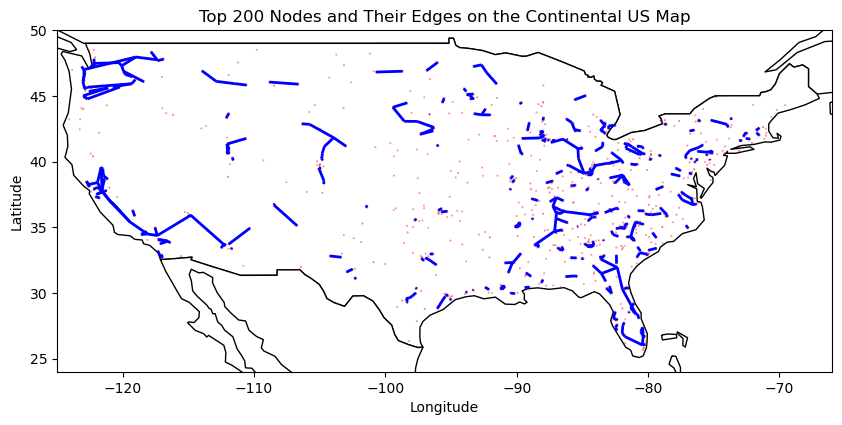

In [16]:
# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the continental US map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# us = world[(world.name == "United States") & (world.subregion.isin(['North America']))]
# continental_us = us[~us['name'].isin(['Hawaii', 'Alaska'])]  # Assuming Alaska and Hawaii are excluded
# continental_us.plot(ax=ax, color='white', edgecolor='black')

# Define bounding box for CONUS
lon_min, lon_max = -125, -66
lat_min, lat_max = 24, 50

# Filter the world GeoDataFrame to get only the continental US
continental_us = world.cx[lon_min:lon_max, lat_min:lat_max]
continental_us.plot(ax=ax, color='white', edgecolor='black')


# Plot the edges
edges_gdf.plot(ax=ax, color='blue', linewidth=2)

# Plot the nodes with sizes based on degree centrality
node_sizes = [centrality[node] * 1000 for node in top_X_nodes]  # Scale sizes
nodes_gdf.plot(ax=ax, color='red', markersize=node_sizes, alpha=0.6)

# Set aspect ratio to be equal for correct map projection
ax.set_aspect('equal')

# Set plot limits to match the bounding box
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)


plt.title("Top 200 Nodes and Their Edges on the Continental US Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Analyze the physical network

#### Basic statistics


Number of nodes: 70393
Number of edges: 85136
Average degree: 2.418876876962198
Network density: 3.436295142860265e-05


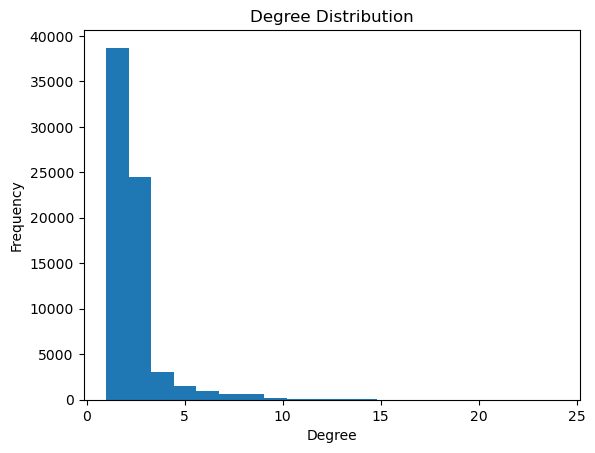

In [17]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_degree = sum(dict(G.degree()).values()) / float(num_nodes)
density = nx.density(G)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {avg_degree}")
print(f"Network density: {density}")

# Plot degree distribution
degree_sequence = [d for n, d in G.degree()]
plt.hist(degree_sequence, bins=20)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


#### Centrality Measures

In [ ]:
# Centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Get top nodes by centrality
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes by degree centrality:", sorted_degree)
print("Top 10 nodes by betweenness centrality:", sorted_betweenness)


#### Path Length and Network Efficiency

In [ ]:
# Shortest path length
avg_shortest_path_length = nx.average_shortest_path_length(G)

# Diameter
diameter = nx.diameter(G)

print(f"Average shortest path length: {avg_shortest_path_length}")
print(f"Network diameter: {diameter}")


#### Connectivity and resilience

In [ ]:
# Identify connected components
connected_components = list(nx.connected_components(G))
print(f"Number of connected components: {len(connected_components)}")

# Node connectivity
node_connectivity = nx.node_connectivity(G)
print(f"Node connectivity: {node_connectivity}")

# Edge connectivity
edge_connectivity = nx.edge_connectivity(G)
print(f"Edge connectivity: {edge_connectivity}")

# Simulate loss of top 10 nodes by betweenness centrality
G_copy = G.copy()
nodes_to_remove = [node for node, _ in sorted_betweenness]
G_copy.remove_nodes_from(nodes_to_remove)

# Measure the impact on the new graph
new_components = list(nx.connected_components(G_copy))
print(f"Number of components after node removal: {len(new_components)}")


#### Community Detection

In [ ]:
import community as community_louvain

# Run Louvain community detection
partition = community_louvain.best_partition(G)
print(f"Detected {max(partition.values())+1} communities")

# Visualize communities
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, node_color=node_colors, with_labels=False)
plt.show()
